In [1]:
%load_ext autoreload
%autoreload 1
%aimport dependencyGraph.graph
from dependencyGraph.graph import *
import matplotlib

Creating the graph : 
`cmsDriver.py step3 -s RAW2DIGI,RECO,RECOSIM,PAT --datatier GEN-SIM-RECO -n 1 --eventcontent FEVTDEBUGHLT --geometry ExtendedRun4D110 --era Phase2C17I13M9 --procModifiers ticl_v5 --filein file:step2.root --fileout file:step3.root --no_exec --conditions auto:phase2_realistic_T33 `
then adding the following in the config file (at the end):
~~~py
process.FEVTDEBUGHLToutput.outputCommands = [
    "drop *",
    'keep *_patElectronsHGC_*_*',
    'keep *_patPhotonsHGC_*_*',
]

process.load("FWCore.Services.DependencyGraph_cfi")
process.DependencyGraph.showPathDependencies = False
~~~

In [ ]:

G = load_graph("/grid_mnt/vol_home/llr/cms/cuisset/hgcal/tau/prod_taus_v3/producers_graph/dependency_taus.dot")

# the following nodes get removed altogether
to_remove = ['offlineBeamSpot',
 'offlinePrimaryVertices',
 'offlinePrimaryVerticesWithBS',
 'offlineSlimmedPrimaryVertices',
 'prunedGenParticles',
 'firstStepPrimaryVertices',
 'MeasurementTrackerEvent',
 'fixedGridRhoAll'
 'rechitMapProducer']
Gc = G.copy()
Gc.remove_nodes_from(to_remove)

# the following nodes are not removed but all their "consume" edges are removed, effectively cutting the graph after that node (to focus on one interesting area)
def remove_sel(x):
    if x.endswith("SecondaryVertices") or "PrimaryVertices" in x: return True
    # if x.startswith("slimmed") and not "tau" in x and not "Tau" in x: return True
    if x.startswith("ak") and x.endswith("PFJets"): return True
    if "EcalRecHits" in x: return True
    if "RecHit" in x: return True
    return False
to_remove = set(["generalTracks",  "lostTracks", "muons", #"packedPFCandidates", "slimmedPhotons", "slimmedElectrons","particleFlow", "gedPhotons", "gedGsfElectrons", "slimmedElectrons",
    "convLayerPairs", "convClusters", "muons1stStep", "tripletElectronSeeds" , "initialStepSeeds", "highPtTripletStepSeeds",
    "particleFlowClusterHCAL", "hbhereco", "particleFlowClusterECAL"
 ]).union(x for x in Gc.nodes() if remove_sel(x))
Gc.remove_edges_from(list((n, suc) for n in to_remove for suc in Gc.successors(n) ))
len(G), len(Gc), len(G.edges), len(Gc.edges)



(682, 675, 1772, 1322)

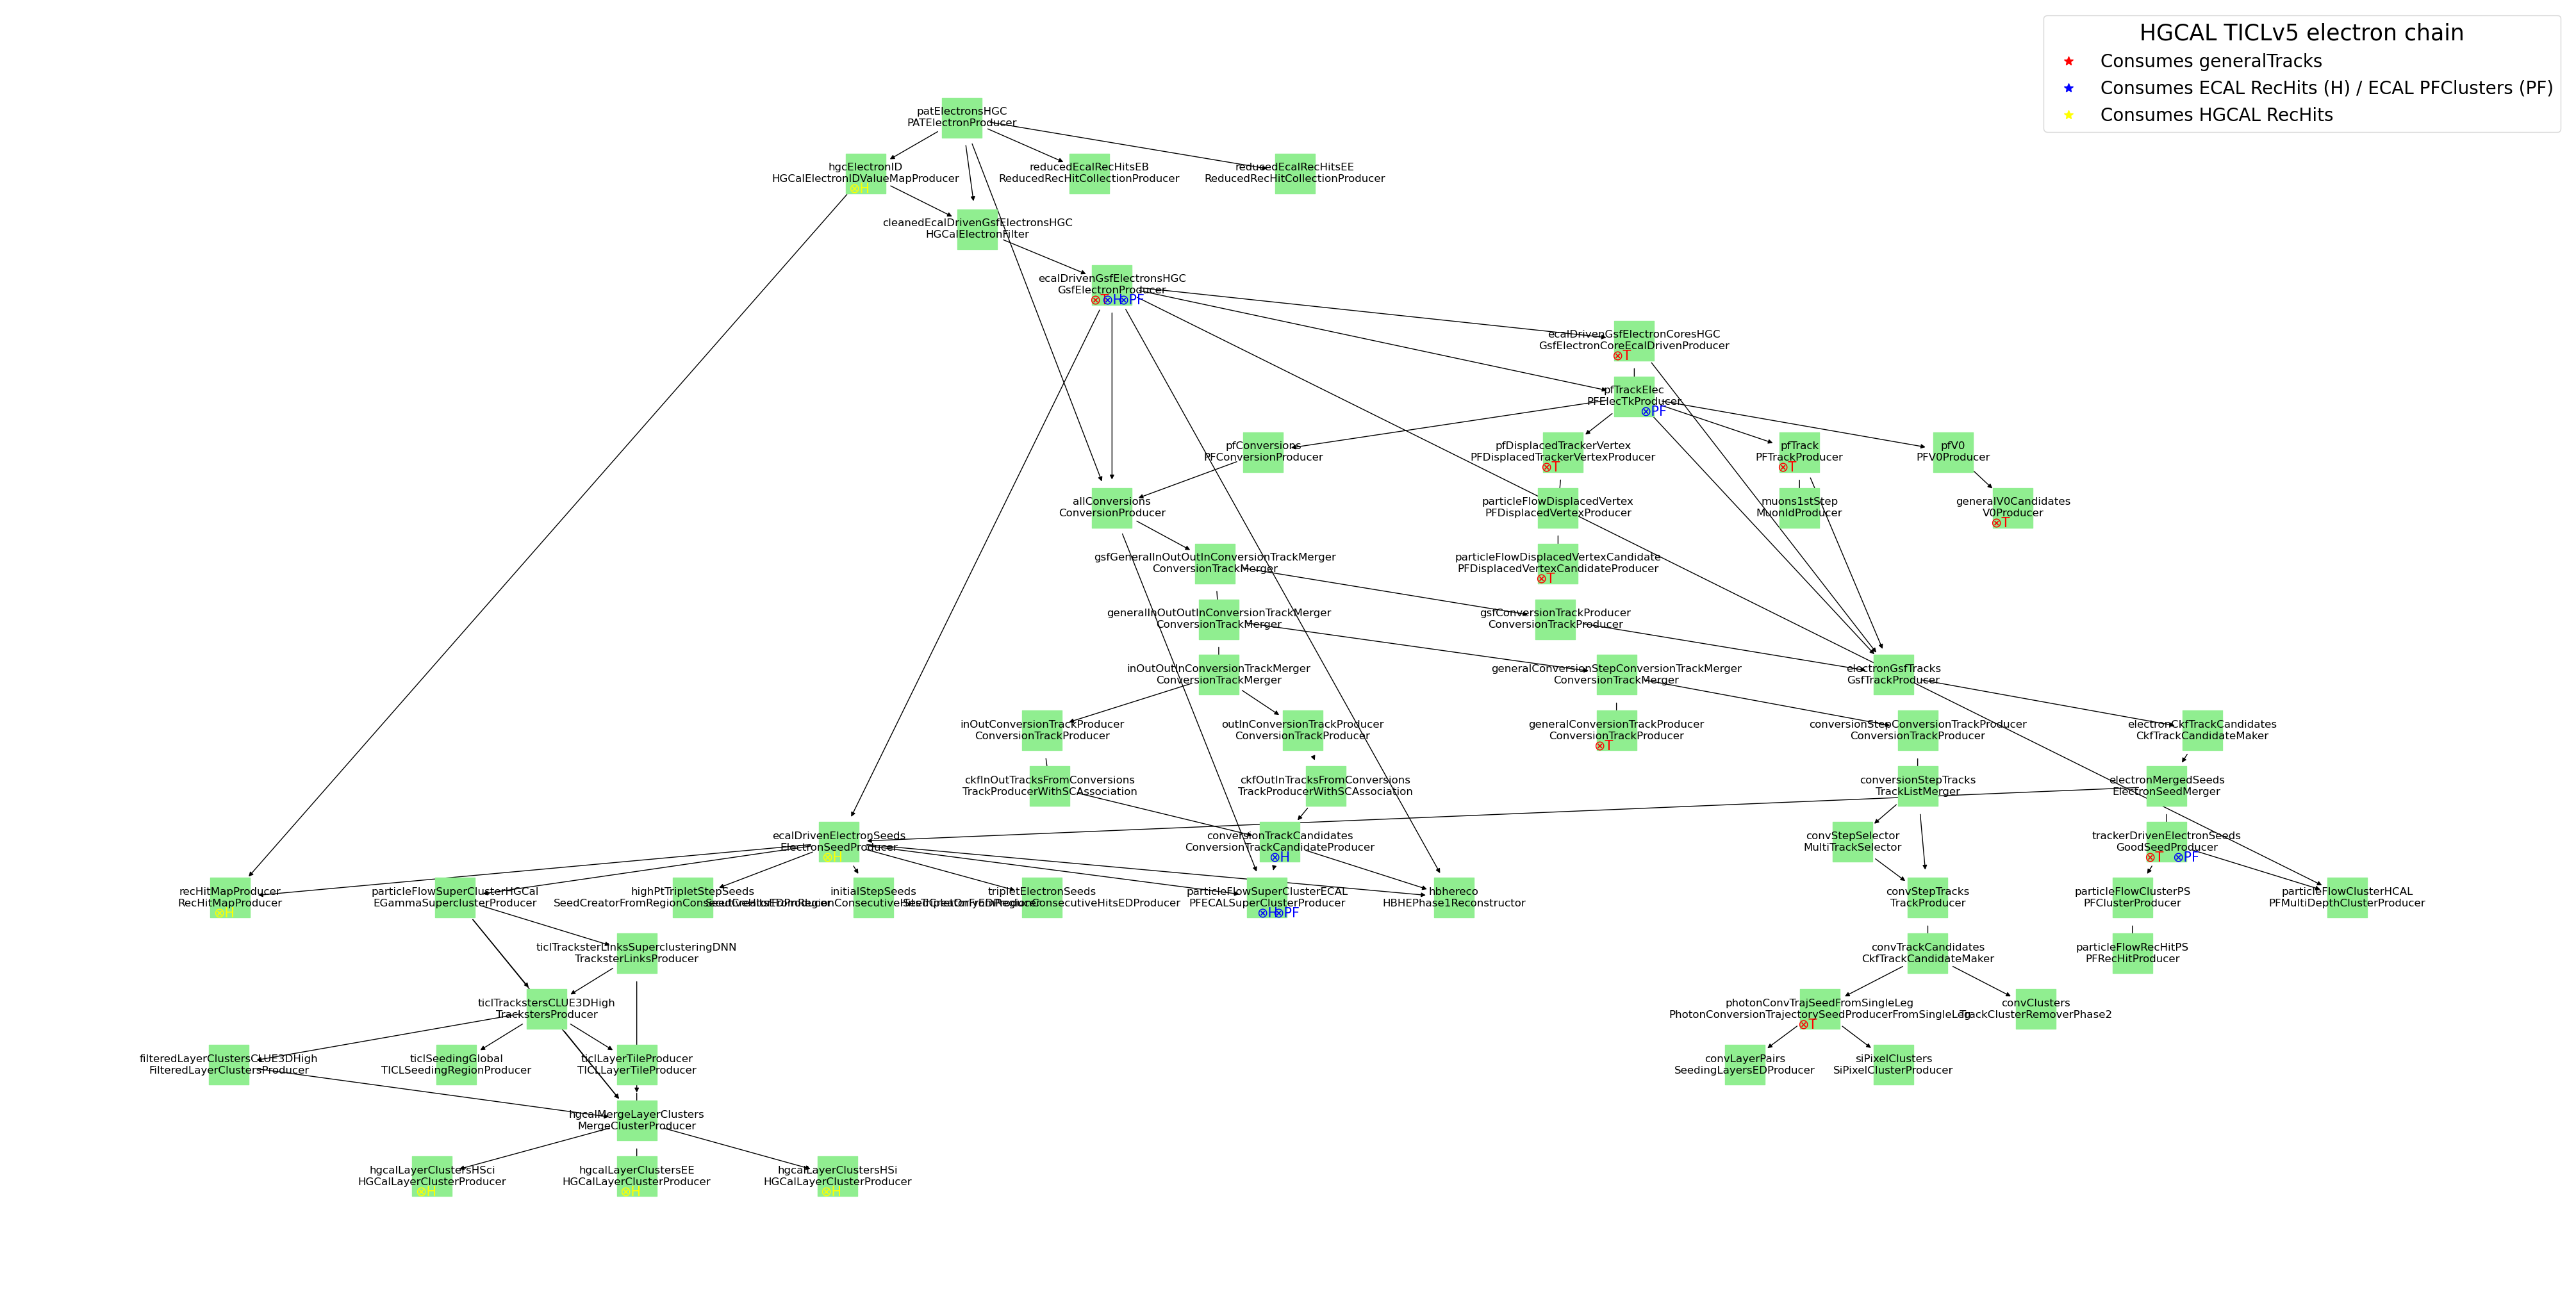

In [7]:
hubs = ["generalTracks","ecalRecHit", "particleFlowClusterECAL", "HGCalRecHit"] 
Gc_cut = ancestors_up_to(Gc, "patElectronsHGC", None)
Gc_cut_noHub = Gc_cut.copy()
Gc_cut_noHub.remove_nodes_from(hubs)
pos = nx.nx_agraph.pygraphviz_layout(Gc_cut_noHub, prog="dot")
plot(Gc_cut_noHub, figsize=(40, 20), pos=pos)


hub_symbol_offset=(-10, -20)
for u in Gc_cut.predecessors("generalTracks"):
    x, y = pos[u]
    mx, my = x + hub_symbol_offset[0], y + hub_symbol_offset[1]  # marker position
    # marker text
    plt.text(
        mx, my, "⊗T",
        fontsize=15,
        ha="center", va="center",
        color="red",
        zorder=1000,
    )
hub_symbol_offset=(0, -20)
for u in Gc_cut.predecessors("ecalRecHit"):
    x, y = pos[u]
    mx, my = x + hub_symbol_offset[0], y + hub_symbol_offset[1]  # marker position
    # marker text
    plt.text(
        mx, my, "⊗H",
        fontsize=15,
        ha="center", va="center",
        color="blue",
        zorder=1000,
    )
hub_symbol_offset=(15, -20)
for u in Gc_cut.predecessors("particleFlowClusterECAL"):
    x, y = pos[u]
    mx, my = x + hub_symbol_offset[0], y + hub_symbol_offset[1]  # marker position
    # marker text
    plt.text(
        mx, my, "⊗PF",
        fontsize=15,
        ha="center", va="center",
        color="blue",
        zorder=1000,
    )
hub_symbol_offset=(-5, -20)
for u in Gc_cut.predecessors("HGCalRecHit"):
    x, y = pos[u]
    mx, my = x + hub_symbol_offset[0], y + hub_symbol_offset[1]  # marker position
    # marker text
    plt.text(
        mx, my, "⊗H",
        fontsize=15,
        ha="center", va="center",
        color="yellow",
        zorder=1000,
    )
plt.legend(
    plt.plot([], "*", color="red", markersize=10) + plt.plot([], "*", color="blue", markersize=10) + plt.plot([], "*", color="yellow", markersize=10), 
    ["Consumes generalTracks", "Consumes ECAL RecHits (H) / ECAL PFClusters (PF)", "Consumes HGCAL RecHits"], 
    fontsize=20, title_fontsize=25, title="HGCAL TICLv5 electron chain")